In [198]:
import pandas as pd
import numpy as np
import requests
import hopsworks
import joblib

In [2]:
%load_ext autoreload
%autoreload 2

/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality


# Importing Air Qualtiy Dataset for Gothenburg year 2023
##### From https://goteborg.se/wps/portal/start/kommun-och-politik/sa-arbetar-goteborgs-stad-med/digitalisering/oppna-data/sok-oppna-data/oppna-data---datamangd#esc_entry=690&esc_context=6

# Data Preprocessing

In [3]:
from air_pred.utils import data_preprocessing

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


Uploading: 0.000%|          | 0/557 elapsed<00:00 remaining<?

In [4]:
FEAURE_GROUP_VERSION = 1
project = hopsworks.login(api_key_file="api_key")
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


# EDA

In [5]:
project = hopsworks.login(api_key_file="api_key")
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
try:
    fg = fs.get_feature_group("air_quality_data")
except:
    from air_pred.pipeline import backfill_feature_pipeline
    fg = backfill_feature_pipeline.backfill_air_quality_data()

In [ ]:
df = fg.read()

In [ ]:
type(df)

In [ ]:
df.describe()

In [ ]:
df.corr()

In [ ]:
df.isna().sum()/len(df) * 100

In [ ]:
df = data_preprocessing.clean_data(df)

In [ ]:
df.columns

In [ ]:
df.isna().sum()/len(df) * 100

In [ ]:
df.describe()

In [ ]:
df.head()

In [957]:
fg = fs.get_feature_group("cleaned_air_quality_data")
df = fg.read()
df.isna().sum()/len(df) * 100

/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `cleaned_air_quality_data`, defaulting to `1`.



Finished: Reading data from Hopsworks, using ArrowFlight (1.43s) 


femman_temp            0.0
femman_rh              0.0
femman_globrad         0.0
femman_airpressure     0.0
femman_windspeed       0.0
femman_winddir         0.0
femman_rain            0.0
femman_no2             0.0
femman_pm10            0.0
femman_nox             0.0
femman_pm25            0.0
haganorra_no2          0.0
haganorra_nox          0.0
hagasodra_pm10         0.0
hagasodra_pm25         0.0
lejonet_globrad        0.0
lejonet_airpressure    0.0
lejonet_rain           0.0
lejonet_rh             0.0
lejonet_temp           0.0
lejonet_winddir        0.0
lejonet_windspeed      0.0
mobil1_no2             0.0
mobil1_nox             0.0
mobil1_pm10            0.0
mobil2_no2             0.0
mobil2_nox             0.0
mobil2_pm10            0.0
mobil3_no2             0.0
mobil3_nox             0.0
mobil3_pm10            0.0
mobil2_pm25            0.0
date_time_str          0.0
date_time              0.0
dtype: float64

# Pipelines

In [976]:
from air_pred.pipeline import backfill_feature_pipeline
from air_pred.pipeline import training_pipeline
from air_pred.pipeline import deployement_pipeline
from air_pred.pipeline import batch_inference_pipeline
from air_pred.pipeline import online_feature_pipeline
from air_pred.pipeline import online_inference_pipeline

In [977]:
backfill_feature_pipeline.backfill_air_quality_data()

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/140436/fs/140355/fg/155990


Uploading Dataframe: 0.00% |          | Rows 0/7089 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/air_quality_data_1_offline_fg_materialization/executions
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/140436/fs/140355/fg/157024


Uploading Dataframe: 0.00% |          | Rows 0/7089 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: cleaned_air_quality_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/cleaned_air_quality_data_1_offline_fg_materialization/executions


In [978]:
training_pipeline.create_featureView()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `cleaned_air_quality_data`, defaulting to `1`.



Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/140436/fs/140355/fv/air_qaulity_baseline_fv/version/1


In [979]:
training_pipeline.create_training_test_data()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/air_qaulity_baseline_fv_1_create_fv_td_25102023061217/executions


/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_view.py:1191: VersionWarning:

Incremented version to `1`.



In [117]:
training_pipeline.train_model()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Train Score : 0.9071571418062164, Test Score : 0.947353115207572
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/140436/models/linear_regression_baseline/1


In [118]:
deployement_pipeline.deploy_linear_regression_baseline()

Connected. Call `.close()` to terminate connection gracefully.
Deployment created, explore it at https://c.app.hopsworks.ai:443/p/140436/deployments/93185
Before making predictions, start the deployment by using `.start()`


  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


Deployment(name: 'lrbasedeployment')

In [987]:
batch_inference_pipeline.create_feature_views()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/140436/fs/140355/fv/predicted_air_quality_regression_fv/version/1


In [934]:
batch_inference_pipeline.batch_predict()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.
Finished: Reading data from Hopsworks, using ArrowFlight (1.73s) 
Finished: Reading data from Hopsworks, using ArrowFlight (1.59s) 
Connected. Call `.close()` to terminate connection gracefully.


/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality/air_pred/pipeline/batch_inference_pipeline.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality/air_pred/pipeline/batch_inference_pipeline.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/140436/fs/140355/fg/157018


Uploading Dataframe: 0.00% |          | Rows 0/7089 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: predicted_air_quality_regression_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/predicted_air_quality_regression_1_offline_fg_materialization/executions


In [983]:
clean_df = online_feature_pipeline.update_feature_groups()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


Uploading Dataframe: 0.00% |          | Rows 0/168 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/air_quality_data_1_offline_fg_materialization/executions
Finished: Reading data from Hopsworks, using ArrowFlight (1.93s) 


Uploading Dataframe: 0.00% |          | Rows 0/168 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: cleaned_air_quality_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/cleaned_air_quality_data_1_offline_fg_materialization/executions


In [986]:
online_inference_pipeline.update_predictions()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `cleaned_air_quality_data`, defaulting to `1`.

/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `predicted_air_quality_regression`, defaulting to `1`.



Finished: Reading data from Hopsworks, using ArrowFlight (0.56s) 


/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality/air_pred/pipeline/online_inference_pipeline.py:33: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Connected. Call `.close()` to terminate connection gracefully.


Uploading Dataframe: 0.00% |          | Rows 0/46 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: predicted_air_quality_regression_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/140436/jobs/named/predicted_air_quality_regression_1_offline_fg_materialization/executions


,date_time,date_time_str,femman_pm25,predicted_femman_pm25
0,2023-10-23 10:00:00,2023-10-23 10:00,5.680450,-72.770052
1,2023-10-23 11:00:00,2023-10-23 11:00,7.644200,6.487529
2,2023-10-23 12:00:00,2023-10-23 12:00,9.317700,8.386669
3,2023-10-23 13:00:00,2023-10-23 13:00,7.101430,5.545478
4,2023-10-23 14:00:00,2023-10-23 14:00,5.637850,1.431397
5,2023-10-23 15:00:00,2023-10-23 15:00,3.595290,1.024799
6,2023-10-23 16:00:00,2023-10-23 16:00,4.887600,5.164036
7,2023-10-23 17:00:00,2023-10-23 17:00,6.386100,11.488380
8,2023-10-23 18:00:00,2023-10-23 18:00,4.261540,8.239994
9,2023-10-23 19:00:00,2023-10-23 19:00,4.228380,-1.244207


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


In [143]:
import datetime
start_date = weeklydf_cleaned.date_time.iloc[0]
end_date = weeklydf_cleaned.date_time.iloc[-1]

In [144]:
fv.init_serving(training_dataset_version=1)
df = fv.get_batch_data(start_time=start_date, end_time=end_date)

Finished: Reading data from Hopsworks, using ArrowFlight (1.27s) 


In [145]:
df.columns

Index(['femman_temp', 'femman_rh', 'femman_globrad', 'femman_airpressure',
       'femman_windspeed', 'femman_winddir', 'femman_rain', 'femman_no2',
       'femman_pm10', 'femman_nox', 'haganorra_no2', 'haganorra_nox',
       'hagasodra_pm10', 'hagasodra_pm25', 'lejonet_globrad',
       'lejonet_airpressure', 'lejonet_rain', 'lejonet_rh', 'lejonet_temp',
       'lejonet_winddir', 'lejonet_windspeed', 'mobil1_no2', 'mobil1_nox',
       'mobil1_pm10', 'mobil2_no2', 'mobil2_nox', 'mobil2_pm10', 'mobil3_no2',
       'mobil3_nox', 'mobil3_pm10', 'mobil2_pm25', 'date_time_str',
       'date_time'],
      dtype='object')

In [146]:
ms = project.get_model_serving()
deployment = ms.get_deployment("lrbasedeployment")

Connected. Call `.close()` to terminate connection gracefully.


In [162]:
testy = weeklydf_cleaned.femman_pm25
testx = df
test_input = testx.drop(["date_time", "date_time_str"], axis = 1).to_numpy().tolist()

In [163]:
plottingdf = pd.concat([testx.date_time, testy], axis =1)
plottingdf["type"] = "actual"
plottingdf = plottingdf.reset_index(drop=True)

In [164]:
prediction = [ deployment.predict(inputs=[input])['predictions'][0] for input in test_input]

In [165]:
pred = [p[0] for p in prediction]

In [178]:
pred_df = pd.concat([testx.date_time, pd.DataFrame(pred,columns=["femman_pm25"])], axis =1)
pred_df["type"] = "predication"
pred_df = pred_df.reset_index(drop=True)
new_df = pd.concat([plottingdf, pred_df])
new_df.reset_index()
new_df["femman_pm25"] = new_df["femman_pm25"].astype(float)

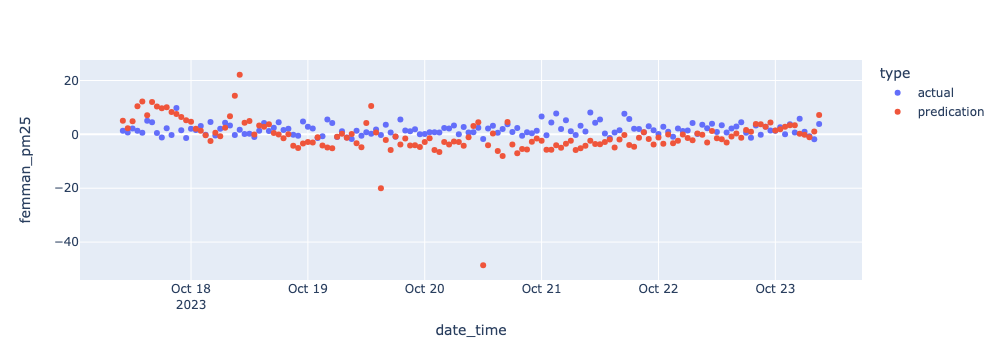

In [179]:
import plotly.express as px

fig = px.scatter(new_df, x="date_time", y="femman_pm25", color="type")
fig.show()

In [175]:
new_df["femman_pm25"].astype(float)

0       1.606800
1       0.821350
2       2.213300
3       7.634950
4       8.129200
         ...    
139    -4.977485
140    -2.331297
141    14.338637
142     4.499670
143    -3.770566
Name: femman_pm25, Length: 312, dtype: float64

# Test code

In [1001]:
project = hopsworks.login(api_key_file="api_key")
fs = project.get_feature_store()
FEAURE_GROUP_VERSION = 1

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


In [1002]:
try:
    predicated_regression_fg = fs.get_feature_group(name="predicted_air_quality_regression",version=FEAURE_GROUP_VERSION)
except:
    predicated_regression_fg = fs.create_feature_group(name="predicted_air_quality_regression",
                                            version=FEAURE_GROUP_VERSION,
                                            description="Predicted air quality in Gothenburg",
                                            online_enabled=True,
                                            primary_key=["date_time_str"],
                                            event_time='date_time')
query = predicated_regression_fg.select_all()
try:
    fv = fs.get_feature_view(name="predicted_air_quality_regression_fv", version=FEAURE_GROUP_VERSION)
except:
    fv = fs.create_feature_view(name="predicted_air_quality_regression_fv",
                                       query=query,
                                       version=FEAURE_GROUP_VERSION,
                                        labels=[],
                                       )

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/140436/featurestores/140355/featureview). Server response: 
HTTP code: 404, HTTP reason: Not Found, body: b'{"errorCode":270009,"usrMsg":"Could not find feature group with ID null","errorMsg":"Featuregroup wasn\'t found."}', error code: 270009, error msg: Featuregroup wasn't found., user msg: Could not find feature group with ID null

In [1011]:
fs = project.get_feature_store()
fg = fs.get_feature_group("cleaned_air_quality_data")
query = fg.select_all()
transformations = {feature.name: fs.get_transformation_function(name="min_max_scaler") \
                   for feature in fg.features if feature.name not in ['femman_pm25', "date_time", "date_time_str"]}
fv = fs.get_or_create_feature_view(name="air_qaulity_baseline_fv_2",
                                   query=query,
                                   version=1,
                                    labels=['femman_pm25']
                                   )

Connected. Call `.close()` to terminate connection gracefully.


/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `cleaned_air_quality_data`, defaulting to `1`.



# Errors

In [632]:
project = hopsworks.login(api_key_file="api_key")
fs = project.get_feature_store()
fg = fs.get_feature_group("cleaned_air_quality_data")
query = data_fg.select_all().\
            join(regression_prediction_fg.select(['predicted_femman_pm25']), on="date_time", join_type = "left").\
            filter(regression_prediction_fg.predicted_femman_pm25 == None)
transformations = {feature.name: fs.get_transformation_function(name="min_max_scaler") \
                   for feature in fg.features if feature.name not in ['femman_pm25', "date_time", "date_time_str"]}
fv = fs.get_or_create_feature_view(name="air_qaulity_baseline_fv_3",
                                   query=query,
                                   version=1,
                                    labels=['femman_pm25'],
                                   transformation_functions=transformations
                                  )

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


/Users/manu/anaconda3/envs/venv_ml/lib/python3.9/site-packages/hsfs/feature_store.py:139: VersionWarning:

No version provided for getting feature group `cleaned_air_quality_data`, defaulting to `1`.



KeyError: 'value'